In [1]:
import tensorflow as tf
import numpy as np
from fbprophet import Prophet
import numpy as np
import pandas as pd
import datetime
import math
import gc
pd.plotting.register_matplotlib_converters()

PATH = 'input/'
START_DATE = '2017-12-01'

In [2]:
train = pd.read_csv(PATH + 'train_transaction.csv')
test = pd.read_csv(PATH + 'test_transaction.csv')

df = pd.concat([train, test], axis = 0, sort = False)
del train, test
gc.collect()

13

In [3]:
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

print(df['TransactionDT'].head())
print(df['TransactionDT'].tail())

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: TransactionDT, dtype: datetime64[ns]
506686   2018-12-31 23:57:59
506687   2018-12-31 23:58:07
506688   2018-12-31 23:58:46
506689   2018-12-31 23:58:57
506690   2018-12-31 23:59:05
Name: TransactionDT, dtype: datetime64[ns]


In [4]:
tm_df = df.groupby(by=df['TransactionDT'].dt.date)["isFraud"].count()

In [5]:
tm_df = tm_df.reset_index()

In [6]:
n_train = 182
n_test = 365 - n_train

In [7]:
tm_df.columns = ["ds", "y"]
tm_df

ds     y
0    2017-12-02  5122
1    2017-12-03  3730
2    2017-12-04  3241
3    2017-12-05  4036
4    2017-12-06  3964
..          ...   ...
360  2018-12-27     0
361  2018-12-28     0
362  2018-12-29     0
363  2018-12-30     0
364  2018-12-31     0

[365 rows x 2 columns]

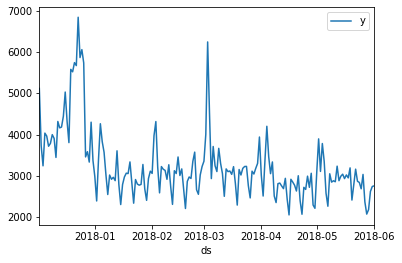

In [8]:
tm_df.iloc[:n_train].plot(x = "ds", y = "y")

In [9]:
m = Prophet()
m.fit(tm_df.iloc[:n_train])

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [10]:
future = m.make_future_dataframe(periods=n_test)
future.tail()


ds
360 2018-11-27
361 2018-11-28
362 2018-11-29
363 2018-11-30
364 2018-12-01

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
360 2018-11-27  1846.966772   992.153545  2747.684863
361 2018-11-28  1827.181300   940.924454  2709.185893
362 2018-11-29  1852.100519   979.619203  2785.779495
363 2018-11-30  1895.507580   975.397776  2831.375642
364 2018-12-01  2304.536074  1338.260264  3202.273821

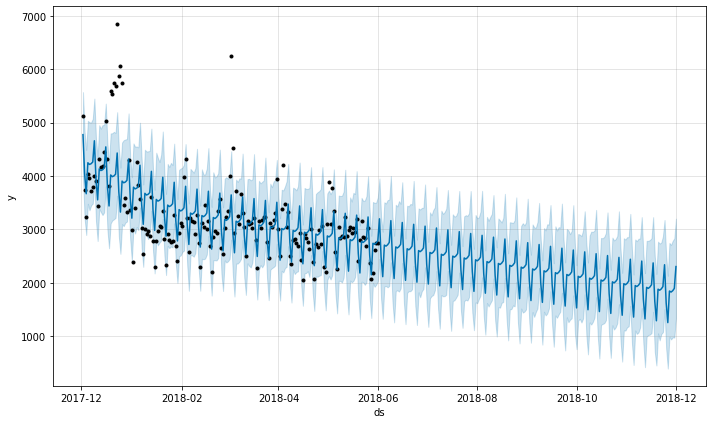

In [12]:
fig1 = m.plot(forecast)

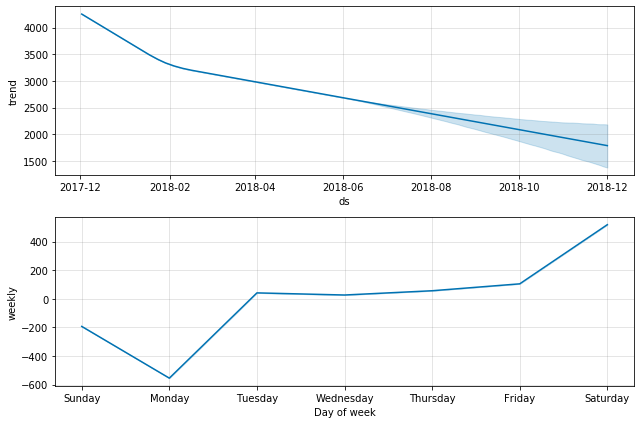

In [13]:
fig2 = m.plot_components(forecast)

In [14]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [15]:
m = Prophet(changepoint_prior_scale=0.3)
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


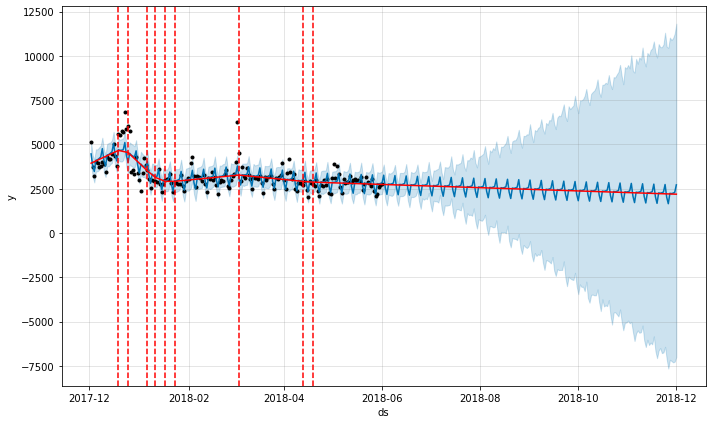

In [16]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [28]:
changepoints = tm_df.iloc[:n_train].nlargest(100, "y")["ds"]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


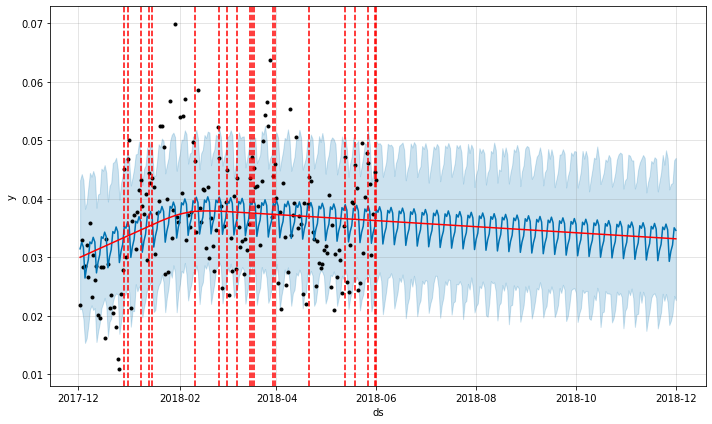

In [29]:
m = Prophet(changepoints=changepoints)
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


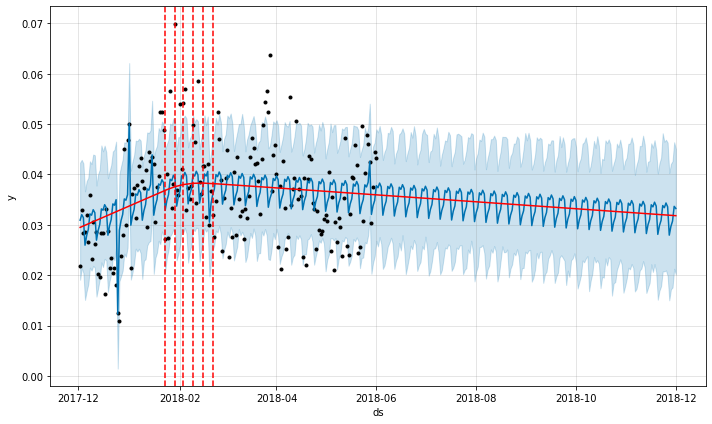

In [30]:
m = Prophet()
m.add_country_holidays(country_name='US')
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


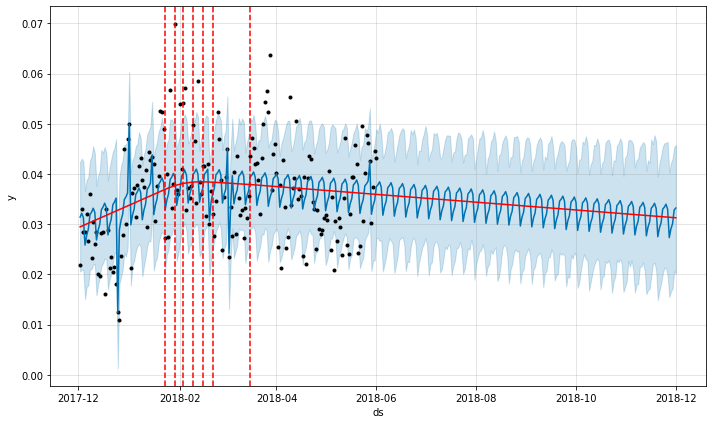

In [31]:
manual_holidays = pd.DataFrame({
  'holiday': 'manual',
  'ds': pd.to_datetime(['2018-03-3']),
  'lower_window': -1,
  'upper_window': 1,
})

m = Prophet(holidays=manual_holidays, changepoint_prior_scale=.05)
m.add_country_holidays(country_name='US')
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [21]:
train_std = tm_df.iloc[:n_train]["y"].std()
train_mean = tm_df.iloc[:n_train]["y"].mean()

In [22]:
tm_df.loc[(tm_df["y"] > (train_mean + 2.5*train_std)), "y"] = np.nan

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


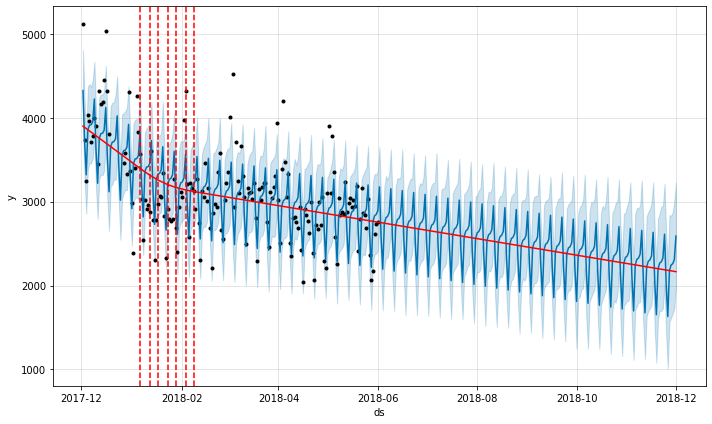

In [23]:
m = Prophet()
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [24]:
tm_df = df.groupby(by=df['TransactionDT'].dt.date)["isFraud"].mean()
tm_df = tm_df.reset_index()
tm_df.columns = ["ds", "y"]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


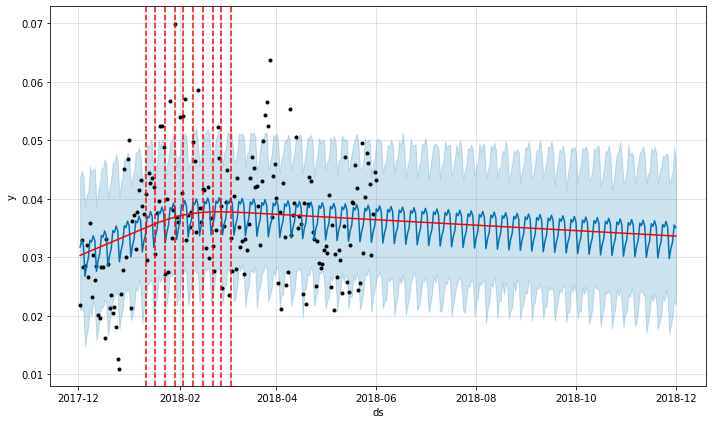

In [25]:
m = Prophet(changepoint_prior_scale=.05)
forecast = m.fit(tm_df.iloc[:n_train]).predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)